# Modelling

Before any modelling the data was standardised. Standardization is one the most common methods of feature scaling and is necessary step before running machine learning models. This is because via standardisation, coefficients are in units of standard deviations of the original predictors. This allows for direct comparison of the magnitude of impact between different predictors. This is key for regularization penalties where the magnitude of coefficients for different predictors must have the same meaning.

All the models were ran via a gridsearchCV. Gridsearching is a method to find the most optimal hyperparameters for a model. It does this by searching over a grid of parameters using internal cross-validation

Each model created three scores: train, test and cross-validation. Train-test split is the most basic type of validation. The idea is that once the data has been split i.e 70:30 the model is trained on the 70%. It is then exposed to the remaining 30% (test data) to see how well it actually performs. Cross-vaidation uses the same concept but repeats the process k times selecting a different random 70:30 distribution everytime.


Models and respective scores (ranked from best to worse):
 
- Random Forest
   - CV: 0.6232582984049593
   - Train: 0.9358817931135459
   - Test: 0.6287650173660536
- Adaboost
   - CV: 0.5804194830520231
   - Train: 0.6049561970765513
   - Test: 0.5980754996299038
- Logistic
   - CV: 0.5655823573739818
   - Train: 0.5667048976304937
   - Test: 0.5694926834823207
- KNN
   - CV: 0.5322481910834485
   - Train: 1.0
   - Test: 0.5402550817058589
- Bayes
   - CV: 0.4265357817719428
   - Train: 0.43791942214304885
   - Test: 0.4375391447930308
- Tensorflow (different notebook)
   - Score: 0.6042247907532882 



Findings from the models:

1) The CV scores range from 0.43 to 0.62 convincingly beating the baseline estimation!

2) From the coefficients we can deduce that:
 - A player, with a team, who moves a lot whilst completing missions is more likely to earn a higher ranked placement.
 - Surprising features were the negative impact of kills in the logistic regression and the positive impact of damage taken. The relationship of kills could either be true (unlikely) or i.e multicollinearity within the data has distorted the coefficent strength/direction. Damage taken happens to have a strong relationship with distance travelled, which suggests a weakness in the data and that time played has not been completely eliminated from the variables (the longer the time played the more chances of getting hit).
 - Another observations is that the weapon/perk choice seems to be insignificant with regards to the outcome of the game at first glance.

3) The curves and matrices indicate that the models performs better in classifying the first and fifth classes but struggle with the middles classes (especially 2 and 3). This is not surprising as the distinction between the middle calsses in the data is much more subtle. There are still a few outliers in the data helping the model differentiate the exterior classes.

In [140]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline
import json
import time
import tqdm
from sklearn.linear_model import LinearRegression
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,KFold,cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
import sklearn.datasets as datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.tree import export_graphviz
import graphviz
import seaborn as sns
import joblib
import pickle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.metrics import precision_score
import scikitplot as skplt
from sklearn.metrics import  plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, roc_auc_score, average_precision_score

In [141]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 10000

In [296]:
df = pd.read_csv('official_wz_update.csv', index_col = 0)

In [423]:
df1 = df.copy()

In [359]:
df2 = df.copy()

In [424]:
cl = []
for value in df1['playerStats.teamPlacement']:
    if value >= 1 and value <= 10:
        cl.append('class_1')
    elif value >= 11 and value <= 20:
        cl.append('class_2')
    elif value >= 21 and value <= 30:
        cl.append('class_3')
    elif value >= 31 and value <= 40:
        cl.append('class_4')
    else :
        cl.append('class_5')
   

In [425]:
df1['playerStats.teamPlacement'] = cl

In [426]:
df1['playerStats.teamPlacement'].value_counts()

class_3    28245
class_2    27217
class_4    24353
class_1    22500
class_5    14769
Name: playerStats.teamPlacement, dtype: int64

In [427]:
reaction = df1.copy()

In [428]:
X = reaction.copy().drop(columns = ['playerStats.teamPlacement'])
y = reaction.copy().pop('playerStats.teamPlacement')

In [429]:
# After the EDA/ feature enginnering class_3 becomes the dominant class
pd.Series(y).value_counts(normalize=True)

class_3    0.241237
class_2    0.232457
class_4    0.207996
class_1    0.192170
class_5    0.126140
Name: playerStats.teamPlacement, dtype: float64

In [430]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                        stratify=y, test_size=0.3, random_state=1)

In [431]:
np.allclose(X_train.index,y_train.index)

True

In [432]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns, index = y_train.index)
X_test = pd.DataFrame(X_test, columns=X.columns, index = y_test.index)

### LOGISTIC REGRESSION

Logistic regression is one of the most frequently used classifiers. It _is_ a regression, but operates as a classifier. It estimates probabilities of class membership. This is done by predicting the so-called log-odds from a kind of regression model.

Logistic regression determins for each datapoint to which of classes (say 0 and 1) it is more likely to belong depending on the observed predictor values.

I see it as the benchmark model

The key parameters are:
Penalty: i.e Ridge(L1) or Lasso(L2)
Solver:i.e. liblinear (performs very well with high dimensionality), Saga
C: the regularization strength (the larger the smaller the regularization)
max_iter: number of iteration steps

In [434]:
model = LogisticRegression(random_state=1, max_iter = 100000)
# different solver

model.fit(X_train, y_train)
print(cross_val_score(model, X_train, y_train, cv=5).mean())
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.5654115475528939
0.5666438907733229
0.5696350281842509


In [435]:
params = {'penalty': ['l1', 'l2'],
                   'solver': ['liblinear', 'Saga','lbfgs'],      
                   'C': np.linspace(0.05, 0.15, 9)}
gs = GridSearchCV(model, params, cv=5, n_jobs=-2, verbose=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  26 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-2)]: Done 122 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-2)]: Done 270 out of 270 | elapsed: 17.1min finished


0.5655823573739818
0.5667048976304937
0.5694926834823207


In [438]:
print('Best Parameters:')
print(gs.best_params_)
print('Best estimator mean cross validated training score:')
print(gs.best_score_)
print('Best estimator score on the full training set:')
print(gs.score(X_train, y_train))
print('Best estimator score on the test set:')
print(gs.score(X_test, y_test))


Best Parameters:
{'C': 0.125, 'penalty': 'l2', 'solver': 'lbfgs'}
Best estimator mean cross validated training score:
0.5655823573739818
Best estimator score on the full training set:
0.5667048976304937
Best estimator score on the test set:
0.5694926834823207


In [161]:
# This looks at the coefficients that affect class_1
df_coef = pd.DataFrame(gs.best_estimator_.coef_[3], index=X_train.columns,
                       columns=['coefficients'])

df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef

,coefficients,coef_abs
teamCount,-0.152314,0.152314
playerStats.kills,-0.541560,0.541560
playerStats.headshots,-0.087412,0.087412
playerStats.assists,-0.068155,0.068155
playerStats.scorePerMinute,-0.210291,0.210291
playerStats.deaths,-0.182116,0.182116
playerStats.kdRatio,0.016775,0.016775
playerStats.gulagDeaths,-0.292966,0.292966
playerStats.gulagKills,0.035378,0.035378
playerStats.percentTimeMoving,-0.218928,0.218928


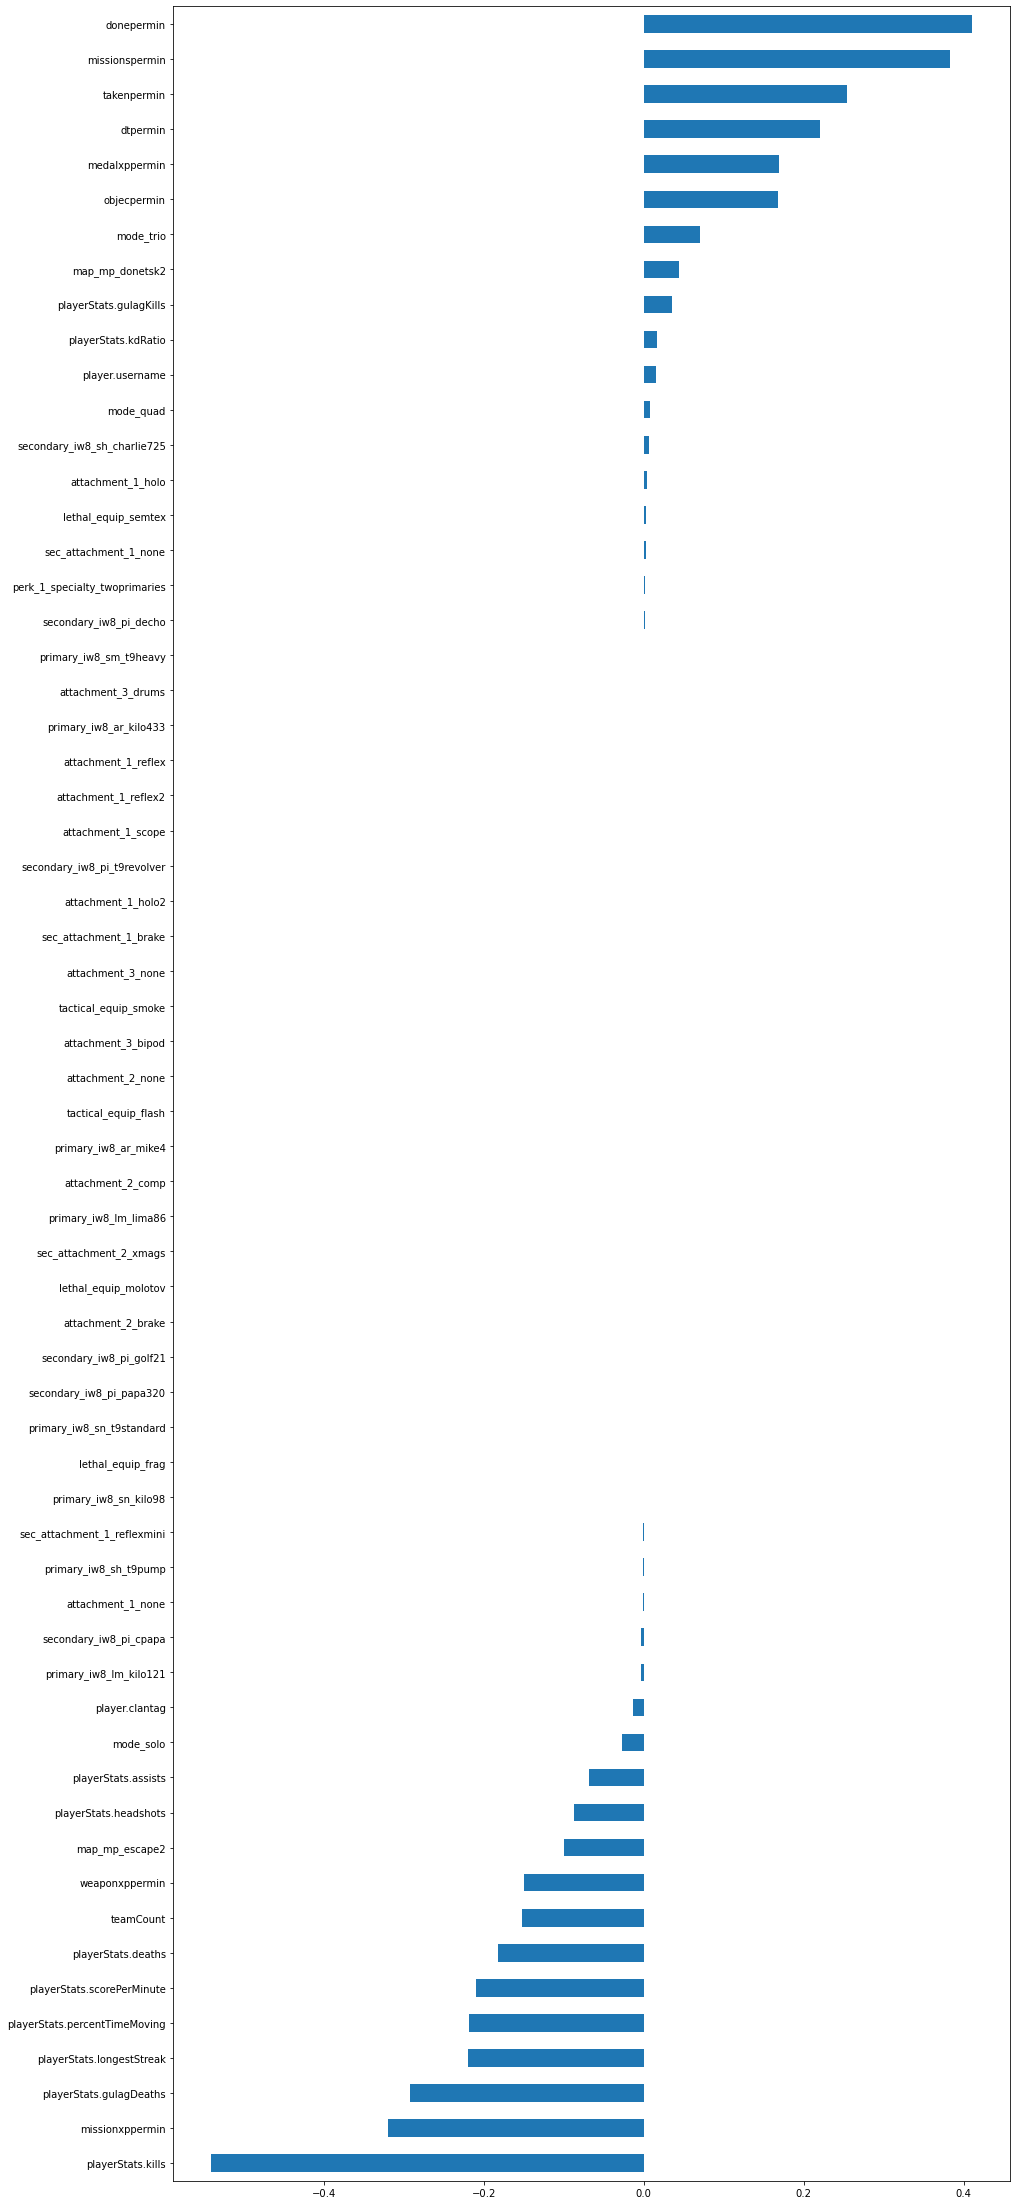

In [162]:
df_coef['coefficients'].sort_values().plot(kind='barh', figsize=(15, 40));

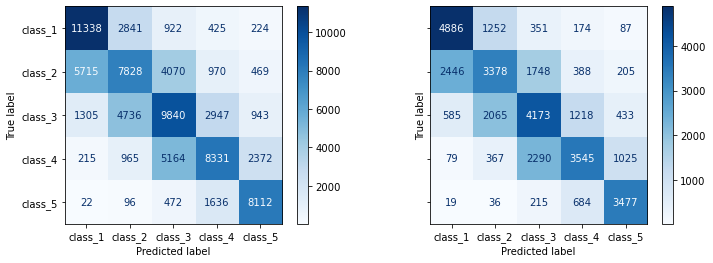

In [163]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
plot_confusion_matrix(gs, X_train, y_train, cmap='Blues', ax=ax[0], normalize= None)
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', ax=ax[1], normalize= None)

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(10)

plt.show()

In [164]:
df1['playerStats.teamPlacement'].value_counts()

class_3    28245
class_2    27217
class_4    24353
class_1    22500
class_5    14769
Name: playerStats.teamPlacement, dtype: int64

In [165]:
predictions_train = gs.predict(X_train)
predictions_test = gs.predict(X_test)

In [166]:
probabilities_train = gs.predict_proba(X_train)
probabilities_test = gs.predict_proba(X_test)

In [167]:
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

     class_1       0.61      0.72      0.66      6750
     class_2       0.48      0.41      0.44      8165
     class_3       0.48      0.49      0.48      8474
     class_4       0.59      0.49      0.53      7306
     class_5       0.67      0.78      0.72      4431

    accuracy                           0.55     35126
   macro avg       0.56      0.58      0.57     35126
weighted avg       0.55      0.55      0.55     35126



In [168]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", len(gs.classes_)))

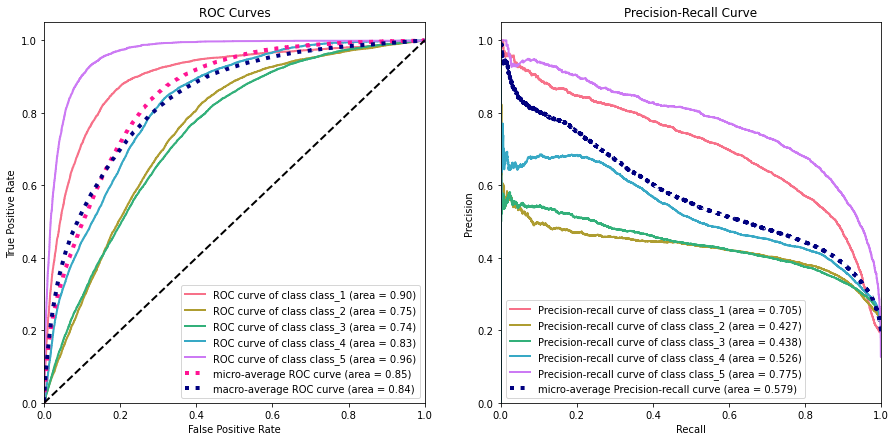

In [169]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,7))
skplt.metrics.plot_roc(y_test, probabilities_test, cmap=cmap, ax = ax[0]);
skplt.metrics.plot_precision_recall(y_test, probabilities_test, cmap=cmap, ax = ax[1]);
plt.show()

### RANDOM FOREST

Random Forests are some of the most widespread classifiers used. They are relatively simple to use because they require very few parameters to set and they perform well. 
 
Random forests are a further way of averaging multiple deep decision trees, trained on different parts of the same training set, with the goal of reducing the variance. This comes at the expense of a small increase in the bias and some loss of interpretability, but generally greatly boosts the performance of the final model.

Parameters:
n_estimators:number of trees in the forest (more trees means more robust model with less variance)
max_depth: the depth of the tree ( the possible number of feature/value combinations that are taken into account. The deeper the tree, the more splits it has and the more information about the data it takes into account)


In [437]:
model = RandomForestClassifier(
                           
                           random_state=1)

tree_params = {
    'max_depth': [10,15,20,25],
    'n_estimators': [300,400,500]
}

# set the gridsearch

gs_random = GridSearchCV(model, tree_params, cv=5,
                      verbose=3, n_jobs=-2, return_train_score=True)
gs_random.fit(X_train, y_train)
print(gs_random.best_score_)
print(gs_random.score(X_train, y_train))
print(gs_random.score(X_test, y_test))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  26 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-2)]: Done  60 out of  60 | elapsed: 37.0min finished


0.6232582984049593
0.9358817931135459
0.6287650173660536


In [439]:
print('Best Parameters:')
print(gs_random.best_params_)
print('Best estimator mean cross validated training score:')
print(gs_random.best_score_)
print('Best estimator score on the full training set:')
print(gs_random.score(X_train, y_train))
print('Best estimator score on the test set:')
print(gs_random.score(X_test, y_test))

Best Parameters:
{'max_depth': 20, 'n_estimators': 500}
Best estimator mean cross validated training score:
0.6232582984049593
Best estimator score on the full training set:
0.9358817931135459
Best estimator score on the test set:
0.6287650173660536


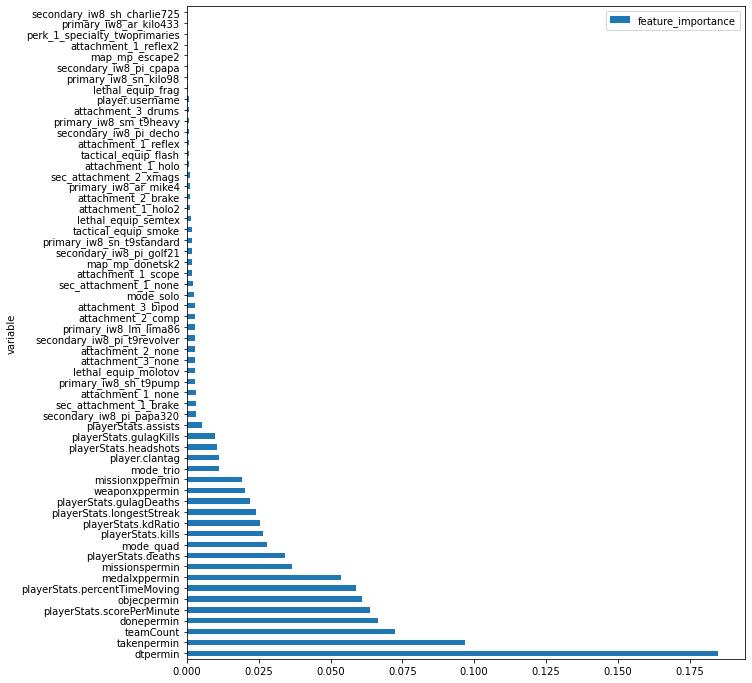

In [173]:
trial = pd.DataFrame({'feature_importance': gs_random.best_estimator_.feature_importances_, 'variable': X.columns})
trial.sort_values('feature_importance', ascending = False, inplace = True)
trial.head(60).plot(kind='barh', x = 'variable', y = 'feature_importance', figsize=(10, 12))
plt.show()

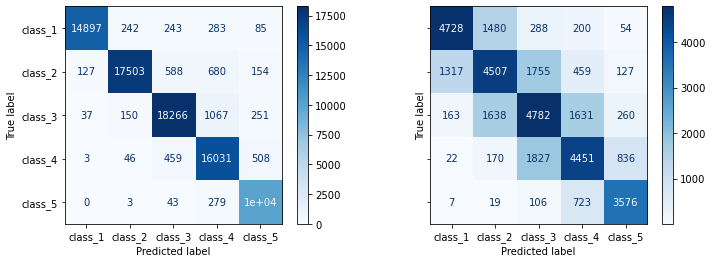

In [174]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
plot_confusion_matrix(gs_random, X_train, y_train, cmap='Blues', ax=ax[0], normalize= None)
plot_confusion_matrix(gs_random, X_test, y_test, cmap='Blues', ax=ax[1], normalize= None)

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(10)

plt.show()

In [175]:
predictions_train_random = gs_random.predict(X_train)
predictions_test_random = gs_random.predict(X_test)

In [176]:
probabilities_train_random = gs_random.predict_proba(X_train)
probabilities_test_random = gs_random.predict_proba(X_test)

In [177]:
print(classification_report(y_test, predictions_test_random))

              precision    recall  f1-score   support

     class_1       0.76      0.70      0.73      6750
     class_2       0.58      0.55      0.56      8165
     class_3       0.55      0.56      0.56      8474
     class_4       0.60      0.61      0.60      7306
     class_5       0.74      0.81      0.77      4431

    accuracy                           0.63     35126
   macro avg       0.64      0.65      0.64     35126
weighted avg       0.63      0.63      0.63     35126



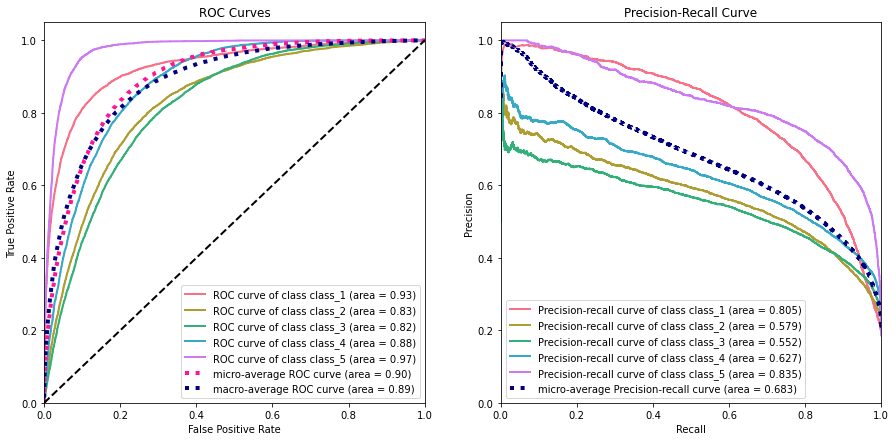

In [178]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,7))
skplt.metrics.plot_roc(y_test, probabilities_test_random, cmap=cmap, ax = ax[0]);
skplt.metrics.plot_precision_recall(y_test, probabilities_test_random, cmap=cmap, ax = ax[1]);
plt.show()

### KNN

K-Nearest Neighbors takes a different approach to modeling than logistic regression. In order to estimate a class membership (classification), the algorithm finds the observations in its training data that are "nearest" to the observation to predict. It then takes a majority vote of those training observations' target values to estimate the value for the new data point.

Parameters:
n_neighbors: number of neighbours
weights: changes the weighting of points depending on their distance from the targeted point
metric: how the distance is calculated

In [180]:
knn_params = {
    'n_neighbors': [25, 40],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']}
knn = KNeighborsClassifier()
gs_knn = GridSearchCV(knn,
                              knn_params,
                              n_jobs=-2, 
                              cv=5, 
                              verbose=3)


gs_knn.fit(X_train, y_train)
print(gs_knn.best_score_)
print(gs_knn.score(X_train, y_train))
print(gs_knn.score(X_test, y_test))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed: 29.5min finished


0.5322481910834485
1.0
0.5402550817058589


In [181]:
print('Best Parameters:')
print(gs_knn.best_params_)
print('Best estimator mean cross validated training score:')
print(gs_knn.best_score_)
print('Best estimator score on the full training set:')
print(gs_knn.score(X_train, y_train))
print('Best estimator score on the test set:')
print(gs_knn.score(X_test, y_test))

Best Parameters:
{'metric': 'euclidean', 'n_neighbors': 40, 'weights': 'distance'}
Best estimator mean cross validated training score:
0.5322481910834485
Best estimator score on the full training set:
1.0
Best estimator score on the test set:
0.5402550817058589


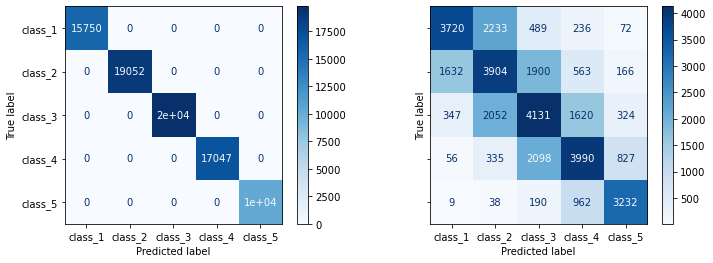

In [184]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
plot_confusion_matrix(gs_knn, X_train, y_train, cmap='Blues', ax=ax[0], normalize= None)
plot_confusion_matrix(gs_knn, X_test, y_test, cmap='Blues', ax=ax[1], normalize= None)

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(10)

plt.show()

In [185]:
predictions_train_knn = gs_knn.predict(X_train)
predictions_test_knn = gs_knn.predict(X_test)

In [186]:
probabilities_train_knn = gs_knn.predict_proba(X_train)
probabilities_test_knn = gs_knn.predict_proba(X_test)

In [187]:
print(classification_report(y_test, predictions_test_knn))

              precision    recall  f1-score   support

     class_1       0.65      0.55      0.59      6750
     class_2       0.46      0.48      0.47      8165
     class_3       0.47      0.49      0.48      8474
     class_4       0.54      0.55      0.54      7306
     class_5       0.70      0.73      0.71      4431

    accuracy                           0.54     35126
   macro avg       0.56      0.56      0.56     35126
weighted avg       0.54      0.54      0.54     35126



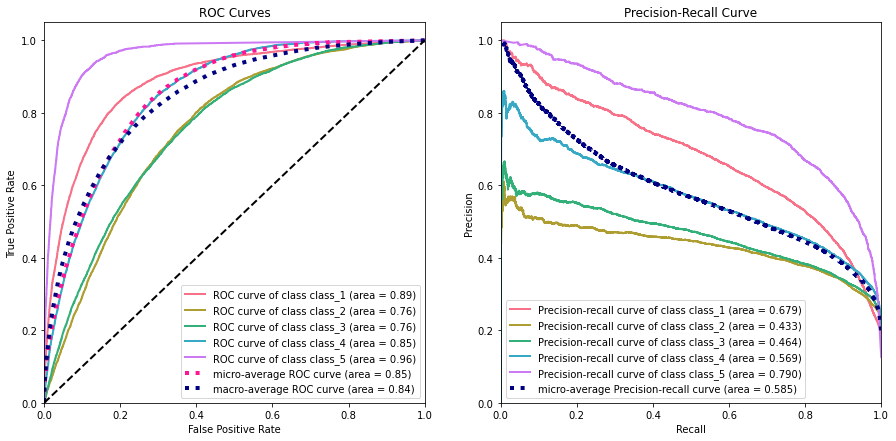

In [188]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,7))
skplt.metrics.plot_roc(y_test, probabilities_test_knn, cmap=cmap, ax = ax[0]);
skplt.metrics.plot_precision_recall(y_test, probabilities_test_knn, cmap=cmap, ax = ax[1]);
plt.show()

This model pefroms less well than its peers but in the same manner

### ADABOOST - DECISIONTREE

The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as a single-split tree) on repeatedly modified versions of the data. After each fit, the importance weights on each observation need to be updated.

The predictions are then combined through a weighted majority vote (or sum) to produce the final prediction. AdaBoost, like all boosting ensemble methods, focuses the next model's fit on the misclassifications/weaknesses of the prior models.

As iterations continue, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence.

In [440]:
base_estimator = DecisionTreeClassifier(max_depth=3, max_features=0.3)
model = AdaBoostClassifier(base_estimator=base_estimator,
                           n_estimators=300,
                           random_state=1)

params = {
    'learning_rate': [0.3,0.4,0.5]
}

# set the gridsearch

gs_boost = GridSearchCV(model, params, cv=5,
                      verbose=3, n_jobs=-2, return_train_score=True)
gs_boost.fit(X_train, y_train)
print(gs_boost.best_score_)
print(gs_boost.score(X_train, y_train))
print(gs_boost.score(X_test, y_test))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  15 out of  15 | elapsed:  9.3min finished


0.5804194830520231
0.6049561970765513
0.5980754996299038


In [442]:
print('Best Parameters:')
print(gs_boost.best_params_)
print('Best estimator mean cross validated training score:')
print(gs_boost.best_score_)
print('Best estimator score on the full training set:')
print(gs_boost.score(X_train, y_train))
print('Best estimator score on the test set:')
print(gs_boost.score(X_test, y_test))

Best Parameters:
{'learning_rate': 0.3}
Best estimator mean cross validated training score:
0.5804194830520231
Best estimator score on the full training set:
0.6049561970765513
Best estimator score on the test set:
0.5980754996299038


In [191]:
fi = pd.DataFrame({
    'feature': X_train.columns,
    'importance': gs_boost.best_estimator_.feature_importances_
})

fi.sort_values('importance', ascending=False, inplace=True)

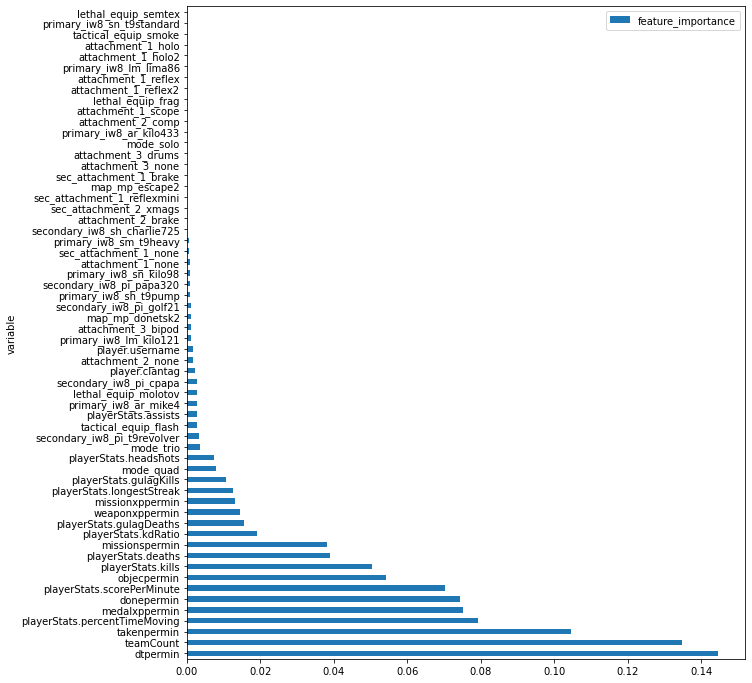

In [192]:
trial = pd.DataFrame({'feature_importance': gs_boost.best_estimator_.feature_importances_, 'variable': X.columns})
trial.sort_values('feature_importance', ascending = False, inplace = True)
trial.head(60).plot(kind='barh', x = 'variable', y = 'feature_importance', figsize=(10, 12))
plt.show()

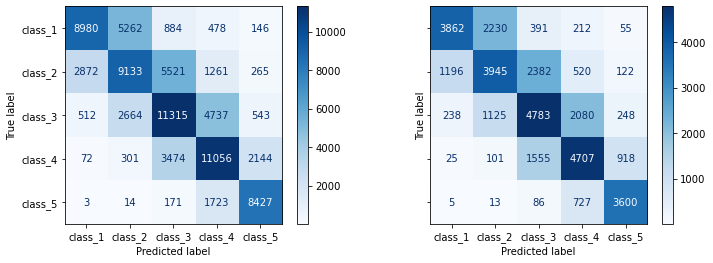

In [193]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
plot_confusion_matrix(gs_boost, X_train, y_train, cmap='Blues', ax=ax[0], normalize= None)
plot_confusion_matrix(gs_boost, X_test, y_test, cmap='Blues', ax=ax[1], normalize= None)

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(10)

plt.show()

In [194]:
predictions_train_boost = gs_boost.predict(X_train)
predictions_test_boost = gs_boost.predict(X_test)

In [195]:
probabilities_train_boost = gs_boost.predict_proba(X_train)
probabilities_test_boost = gs_boost.predict_proba(X_test)

In [196]:
print(classification_report(y_test, predictions_test_boost))

              precision    recall  f1-score   support

     class_1       0.73      0.57      0.64      6750
     class_2       0.53      0.48      0.51      8165
     class_3       0.52      0.56      0.54      8474
     class_4       0.57      0.64      0.61      7306
     class_5       0.73      0.81      0.77      4431

    accuracy                           0.59     35126
   macro avg       0.62      0.62      0.61     35126
weighted avg       0.60      0.59      0.59     35126



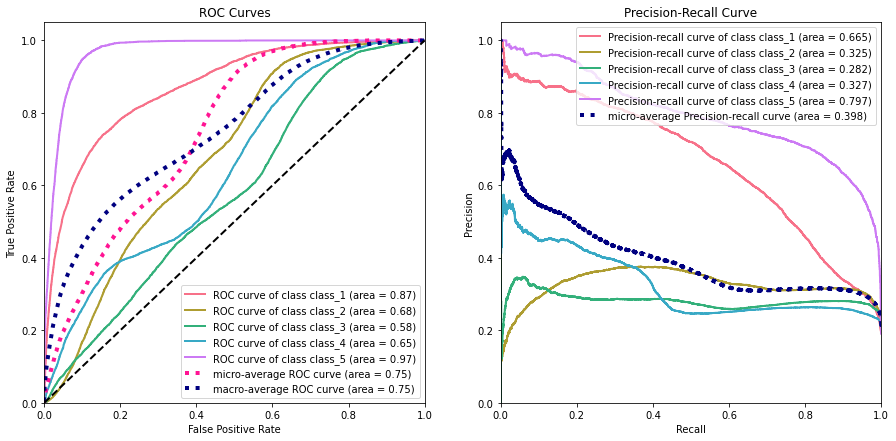

In [197]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,7))
skplt.metrics.plot_roc(y_test, probabilities_test_boost, cmap=cmap, ax = ax[0]);
skplt.metrics.plot_precision_recall(y_test, probabilities_test_boost, cmap=cmap, ax = ax[1]);
plt.show()

### NAIVE BAYES

Naive Bayes is a classification algorithm relying on Bayes' rule to assign class labels  𝑦  for given feature values  𝑋 . As in all other classification models, one is interested in determining the probability of having a certain class label when a certain combination of feature values is obtained


In [443]:
from sklearn import naive_bayes
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

In [202]:
model_bayes = naive_bayes.GaussianNB()
model_bayes.fit(X_train, y_train)


params = {
    'var_smoothing': np.linspace(-1,1,9)
}

# set the gridsearch

gs_bayes = GridSearchCV(model_bayes, params, cv=5,
                      verbose=3, n_jobs=-2, return_train_score=True)
gs_bayes.fit(X_train, y_train)
print(gs_bayes.best_score_)
print(gs_bayes.score(X_train, y_train))
print(gs_bayes.score(X_test, y_test))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  26 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-2)]: Done  45 out of  45 | elapsed:   14.2s finished


0.4265357817719428
0.43791942214304885
0.4375391447930308


In [203]:
print('Best Parameters:')
print(gs_bayes.best_params_)
print('Best estimator mean cross validated training score:')
print(gs_bayes.best_score_)
print('Best estimator score on the full training set:')
print(gs_bayes.score(X_train, y_train))
print('Best estimator score on the test set:')
print(gs_bayes.score(X_test, y_test))

Best Parameters:
{'var_smoothing': 0.5}
Best estimator mean cross validated training score:
0.4265357817719428
Best estimator score on the full training set:
0.43791942214304885
Best estimator score on the test set:
0.4375391447930308


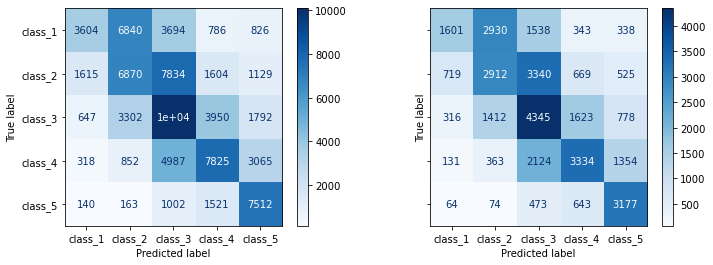

In [205]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
plot_confusion_matrix(gs_bayes, X_train, y_train, cmap='Blues', ax=ax[0], normalize= None)
plot_confusion_matrix(gs_bayes, X_test, y_test, cmap='Blues', ax=ax[1], normalize= None)

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(10)

plt.show()

In [206]:
predictions_train_bayes = gs_bayes.predict(X_train)
predictions_test_bayes = gs_bayes.predict(X_test)

In [207]:
probabilities_train_bayes = gs_bayes.predict_proba(X_train)
probabilities_test_bayes = gs_bayes.predict_proba(X_test)

In [208]:
print(classification_report(y_test, predictions_test_bayes))

              precision    recall  f1-score   support

     class_1       0.57      0.24      0.33      6750
     class_2       0.38      0.36      0.37      8165
     class_3       0.37      0.51      0.43      8474
     class_4       0.50      0.46      0.48      7306
     class_5       0.51      0.72      0.60      4431

    accuracy                           0.44     35126
   macro avg       0.47      0.46      0.44     35126
weighted avg       0.46      0.44      0.43     35126

